# GPe prototypical neuron model

Lindahl M, Hellgren Kotaleski J. Untangling Basal Ganglia Network Dynamics and Function: Role of Dopamine Depletion and Inhibition Investigated in a Spiking Network Model. eNeuro. 2017 Jan 12;3(6):ENEURO.0156-16.2016. doi: 10.1523/ENEURO.0156-16.2016. PMID: 28101525; PMCID: PMC5228592.

In [1]:
import numpy as np
import nest
nest.set_verbosity('M_WARNING')
nest.ResetKernel()

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [3]:
model = 'aeif_cond_exp'
params = {'a': 2.5,
          'b': 70.0,
          'V_th': -54.7,
          'Delta_T': 1.7,
          'I_e': 12.0,
          'C_m': 40.0,
          'g_L': 1.0,
          'V_reset': -60.0,
          'tau_w': 20.0,
          't_ref': 1.0,
          'V_peak': 15.0,
          'E_L': -55.1,
          'E_ex': 0.,
          'E_in': -70.}

In [4]:
stimuli = np.linspace(-60., 38., 20)

In [5]:
def output(stim):
    nest.ResetKernel()
    neuron = nest.Create(model, params=params)
    I_e = nest.GetStatus(neuron, 'I_e')[0]
    nest.SetStatus(neuron, {'I_e': I_e + stim})
    multimeter = nest.Create("multimeter")
    nest.SetStatus(multimeter, {"record_from":["V_m", "w"]})
    nest.Connect(multimeter, neuron)
    spike_detector = nest.Create('spike_recorder')
    nest.Connect(neuron, spike_detector)
    nest.Simulate(1000.0)
    rate = nest.GetStatus(spike_detector,keys="n_events")[0]
    trace = nest.GetStatus(multimeter)[0]
    return rate, trace

In [6]:
outputs = [output(stim) for stim in stimuli]

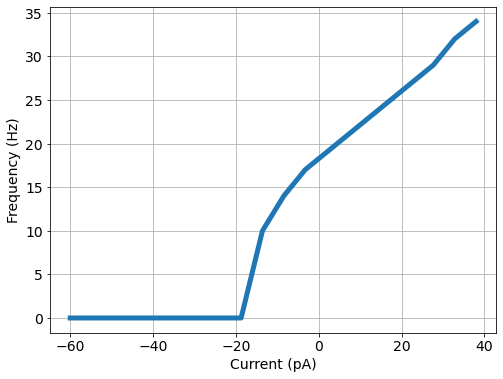

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
rates = [rate for rate, trace in outputs]
ax.plot(stimuli, rates, linewidth=5)
ax.grid()
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Frequency (Hz)');

In [8]:
def with_peaks(time, volt, vreset, vpeak):
    t, v = [], []
    x0, y0 = 0., 0.
    for x, y in zip(time, volt):
        if abs(y - vreset) < 1e-3 and abs(y - y0) > 10.:
            v.append(vpeak)
            t.append((x0 + x)/2.0)
        v.append(y)
        t.append(x)
        x0, y0 = x, y
    return np.array(t), np.array(v)

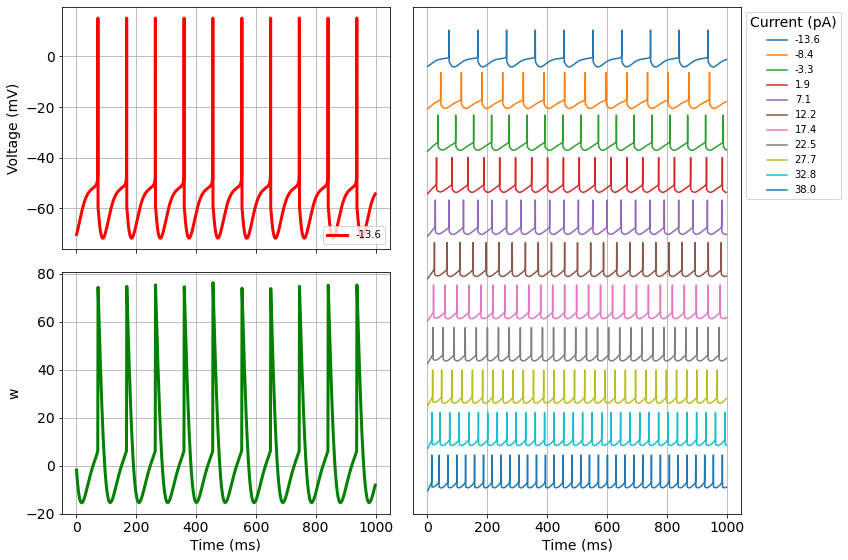

In [9]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(221)
ax3 = fig.add_subplot(223)
ax2 = fig.add_subplot(122)
i = 0
vreset = params['V_reset']
vpeak = params['V_peak']
for stim, (rate, trace) in zip(stimuli, outputs):
    if rate:
        ts = trace["events"]["times"]
        vs = trace["events"]["V_m"]
        tp, vp = with_peaks(ts, vs, vreset, vpeak)
        ax2.plot(tp, vp - i*100, label=str(round(stim, 1)))
        if i == 0:
            ws = trace["events"]["w"]
            ax1.plot(tp, vp, linewidth=3, color='r', label=str(round(stim, 1)))
            ax3.plot(ts, ws, linewidth=3, color='g')
        i += 1
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('Voltage (mV)')
ax1.legend(loc='lower right', fontsize=10)
ax2.set_yticks([])
ax2.legend(title='Current (pA)', bbox_to_anchor=(1, 1), fontsize=10)
ax2.set_xlabel('Time (ms)')
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('w')
ax1.grid()
ax2.grid()
ax3.grid()
fig.tight_layout();